# GANs to create more image samples of skin lesions

In [1]:
# import libraries
import os
import sys
import PIL
import time
import glob
import imageio
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
from IPython import display
from subprocess import call
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'2.1.0'

In [3]:
from google.api_core import page_iterator
from google.cloud import storage
from io import BytesIO

## Input Pipeline

In [4]:
# create a data generator
# datagen = ImageDataGenerator()

In [5]:
CLASS_NAMES = np.array([item.name for item in pathlib.Path('../../data/train').glob('*')])

In [6]:
CLASS_NAMES

array(['pityriasis-versicolor', 'kaposi-sarcoma-patch-plaque-nodule',
       'scabies', 'atopic-dermatitis-eczema', 'pityriasis-rosea',
       'lichen-planus', 'mycosis-fungoides-mf-plaque', 'psoriasis',
       'vitiligo', 'mycosis-fungoides-mf-patch',
       'seborrhoeic-dermatitis-eczema', 'mycosis-fungoides-mf-nodular',
       'granuloma-annulare'], dtype='<U34')

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 28 #224
IMG_WIDTH = 28 #224
CLASS_SIZE = len(CLASS_NAMES)
# STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [8]:
def make_train_generator():
    train_datagen = ImageDataGenerator()#rescale=1. / 255)
    train_generator = train_datagen.flow_from_directory(
        '../../data/train_r',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
        class_mode='binary',
        classes = list(CLASS_NAMES))
    return train_generator

In [9]:
def make_test_generator():
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    test_generator = test_datagen.flow_from_directory(
        '../../data/test_r',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
#         batch_size=BATCH_SIZE,
        class_mode='binary',
        classes = list(CLASS_NAMES))
    return test_generator

In [68]:
def get_dataset_adapter(split: str):
    if split == 'train':
        return tf.data.Dataset.from_generator(make_train_generator, (tf.float32, tf.float32)).unbatch()
    else:
        return tf.data.Dataset.from_generator(make_test_generator, (tf.float32, tf.float32)).unbatch()

In [72]:
@tf.autograph.experimental.do_not_convert
def input_fn(mode, params):
    assert 'batch_size' in params
    assert 'noise_dims' in params
    bs = params['batch_size']
    nd = params['noise_dims']
    split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
    shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
    just_noise = (mode == tf.estimator.ModeKeys.PREDICT)

    noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random.normal([bs, nd])))

    if just_noise:
        return noise_ds

    def _preprocess(element):
        # Map [0, 255] to [-1, 1].
        images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
        return images

    images_ds = (get_dataset_adapter(split=split)
               .cache()
               .repeat())
    if shuffle:
        images_ds = images_ds.shuffle(
            buffer_size=10000, reshuffle_each_iteration=True)
    images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

    return tf.data.Dataset.zip((noise_ds, images_ds))

## Sanity check the inputs

Found 254 images belonging to 13 classes.


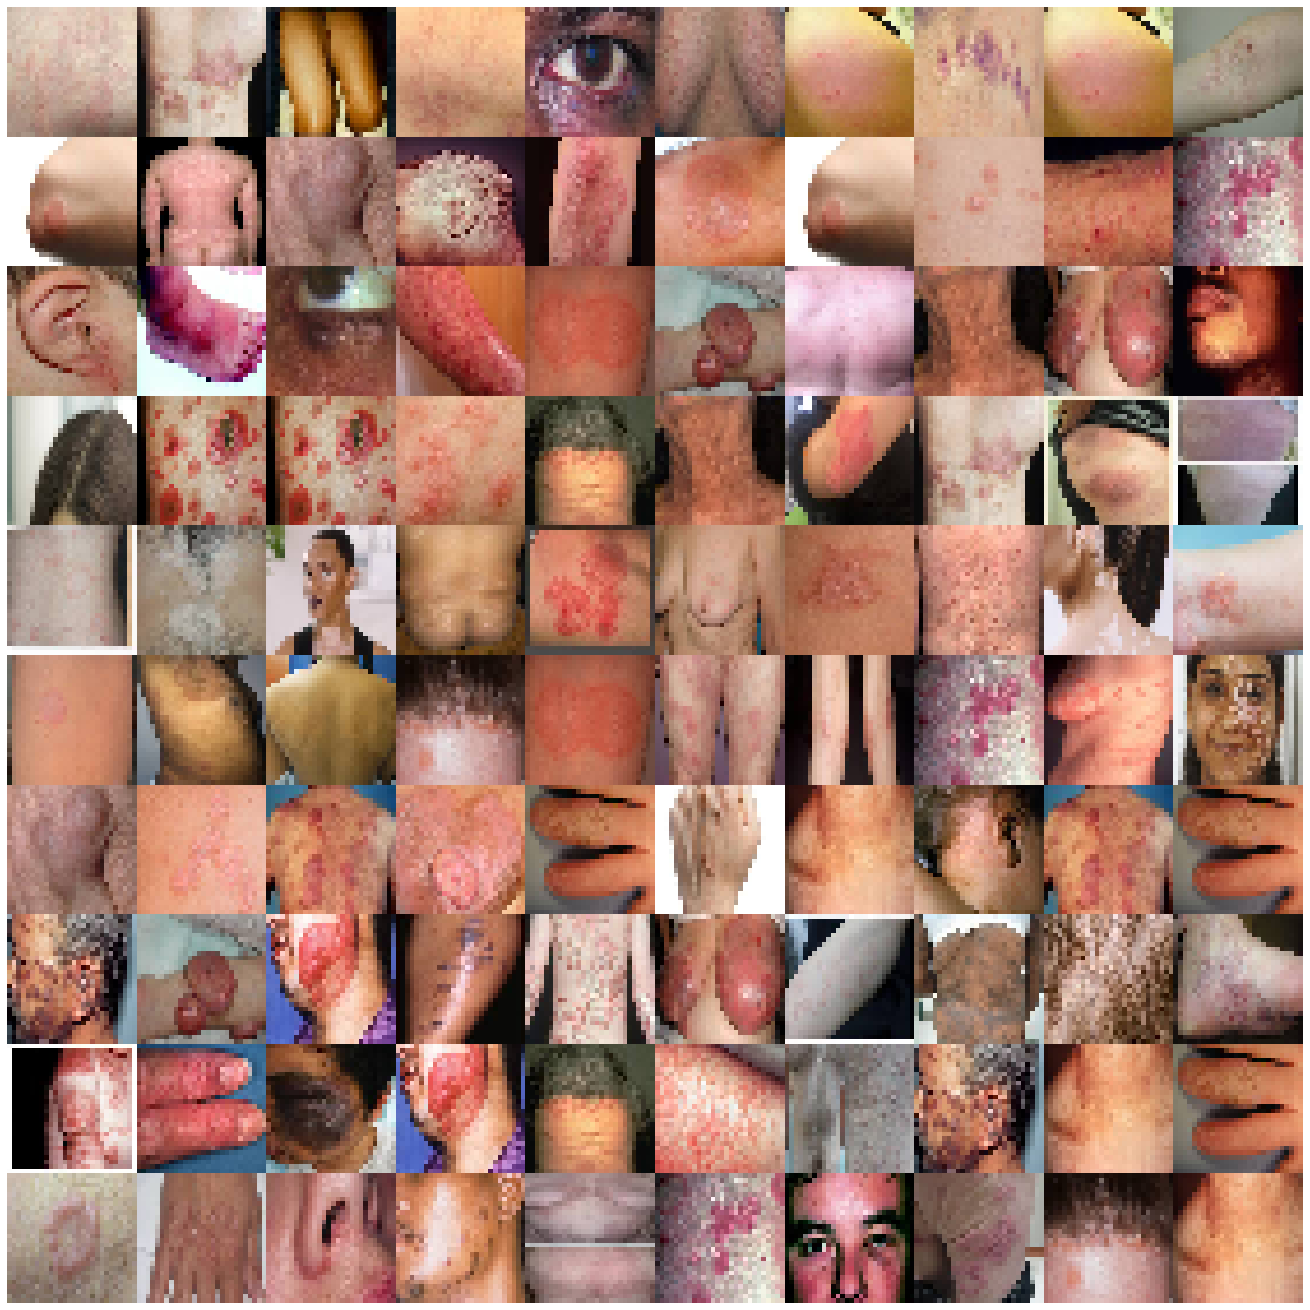

In [81]:
params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
    ds = input_fn(tf.estimator.ModeKeys.TRAIN, params)
    numpy_imgs = next(tfds.as_numpy(ds))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs[0], grid_shape=(10, 10))

plt.figure(figsize=(18,18))
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(np.squeeze(img_grid).astype(np.uint8))
plt.show()

## Neural Network Architecture

In [85]:
def _leaky_relu(x):
      return tf.nn.leaky_relu(x, alpha=0.2)


def _batch_norm(x, is_training, name):
    return tf.layers.batch_normalization(
        x, momentum=0.9, epsilon=1e-5, training=is_training, name=name)


def _dense(x, channels, name):
    return tf.layers.dense(
        x, channels,
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
        name=name)


def _conv2d(x, filters, kernel_size, stride, name):
    return tf.layers.conv2d(
        x, filters, [kernel_size, kernel_size],
        strides=[stride, stride], padding='same',
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
        name=name)


def _deconv2d(x, filters, kernel_size, stride, name):
    return tf.layers.conv2d_transpose(
        x, filters, [kernel_size, kernel_size],
        strides=[stride, stride], padding='same',
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
        name=name)

In [86]:
def discriminator(images, unused_conditioning, is_training=True,
                  scope='Discriminator'):
    """Discriminator for CIFAR images.

    Args:
    images: A Tensor of shape [batch size, width, height, channels], that can be
      either real or generated. It is the discriminator's goal to distinguish
      between the two.
    unused_conditioning: The TFGAN API can help with conditional GANs, which
      would require extra `condition` information to both the generator and the
      discriminator. Since this example is not conditional, we do not use this
      argument.
    is_training: If `True`, batch norm uses batch statistics. If `False`, batch
      norm uses the exponential moving average collected from population
      statistics.
    scope: A variable scope or string for the discriminator.

    Returns:
    A 1D Tensor of shape [batch size] representing the confidence that the
    images are real. The output can lie in [-inf, inf], with positive values
    indicating high confidence that the images are real.
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        x = _conv2d(images, 64, 5, 2, name='d_conv1')
        x = _leaky_relu(x)

        x = _conv2d(x, 128, 5, 2, name='d_conv2')
        x = _leaky_relu(_batch_norm(x, is_training, name='d_bn2'))

        x = _conv2d(x, 256, 5, 2, name='d_conv3')
        x = _leaky_relu(_batch_norm(x, is_training, name='d_bn3'))

        x = tf.reshape(x, [-1, 4 * 4 * 256])

        x = _dense(x, 1, name='d_fc_4')

        return x

In [88]:
def generator(noise, is_training=True, scope='Generator'):
    """Generator to produce CIFAR images.

    Args:
    noise: A 2D Tensor of shape [batch size, noise dim]. Since this example
      does not use conditioning, this Tensor represents a noise vector of some
      kind that will be reshaped by the generator into CIFAR examples.
    is_training: If `True`, batch norm uses batch statistics. If `False`, batch
      norm uses the exponential moving average collected from population
      statistics.
    scope: A variable scope or string for the generator.

    Returns:
    A single Tensor with a batch of generated CIFAR images.
    """
    with tf.variable_scope(scope, reuse=tf.AUTO_REUSE):
        net = _dense(noise, 4096, name='g_fc1')
        net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn1'))

        net = tf.reshape(net, [-1, 4, 4, 256])

        net = _deconv2d(net, 128, 5, 2, name='g_dconv2')
        net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn2'))

        net = _deconv2d(net, 64, 4, 2, name='g_dconv3')
        net = tf.nn.relu(_batch_norm(net, is_training, name='g_bn3'))

        net = _deconv2d(net, 3, 4, 2, name='g_dconv4')
        net = tf.tanh(net)

        return net

## Eval Utilities

In [89]:
eval_batch_size = 4000
images_per_batch = 2000

def get_real_image_logits(num_images, classifier_model):
    """Returns an array with logits from real images and a CIFAR classifier.

    We normally want many thousands of examples to run eval. However, we can't fit
    inference for all of them in memory at once. Instead, we use TF-GAN eval utils
    to more efficiently manage memory.

    Args:
    num_images: Total number of images to produce logits for.
    classifier_model: A Python function that takes images and produces logits.

    Returns:
    A numpy array of logits of shape close to [num_images, ?].
    """
    ds = input_fn(tf.estimator.ModeKeys.TRAIN, 
                {'batch_size': images_per_batch, 'noise_dims': 1})
    iterator = tf.data.make_one_shot_iterator(ds)

    real_logits = tfgan.eval.sample_and_run_classifier_fn(
        sample_fn=lambda _: iterator.get_next()[1],
        sample_inputs=[0.0] * (num_images // images_per_batch),  # unused
        classifier_fn=classifier_model)

    with tf.train.MonitoredSession() as sess:
        logits = sess.run(real_logits)
    assert len(logits.shape) == 2
    assert logits.shape[0] == num_images
    return logits

In [92]:
def init_global_real_logits():
    """Initialize a global variable with classifier logits for real data."""
    # We can hold all the real logits in memory at once, since CIFAR10 isn't that
    # big. Be sure to calculate it only once.
    global real_logits
    try:
        real_logits is not None
    except NameError:
        with tf.Graph().as_default():
            classifier_model = hub.Module("https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1")
            real_logits = get_real_image_logits(
                eval_batch_size, classifier_model)
    assert real_logits.shape == (eval_batch_size, 10)

In [93]:
def calculate_real_data_classifier_score():
    """Calculate the classifier score on real data logits."""
    assert real_logits is not None
    classifier_score = tfgan.eval.classifier_score_from_logits(real_logits)
    with tf.train.MonitoredSession() as sess:
        cscore_real = sess.run(classifier_score)
    return cscore_real

In [96]:
def get_inception_score_and_fid(est):
    """Calculate our evaluation metrics."""
    global real_logits
    assert real_logits is not None

    tf.reset_default_graph()
    classifier_model = hub.Module("https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1")

    # We dont' want to hold all the images and activations at once, so use a
    # memory-efficient utility.
    def sample_fn(_):
        predictions = np.array([x['generated_data'] for x in est.predict(input_fn)])
        assert predictions.shape == (images_per_batch, 32, 32, 3)
        return predictions
    fake_logits = tfgan.eval.sample_and_run_classifier_fn(
        sample_fn=sample_fn,
        sample_inputs=[0.0] * (eval_batch_size // images_per_batch),  # unused
        classifier_fn=classifier_model)
    fake_logits.shape.assert_is_compatible_with([eval_batch_size, 10])

    classifier_score = tfgan.eval.classifier_score_from_logits(fake_logits)
    fid = tfgan.eval.frechet_classifier_distance_from_activations(
        real_logits, fake_logits)

    with tf.train.MonitoredSession() as sess:
        cscore_np, fid_np = sess.run([classifier_score, fid])
  
    return cscore_np, fid_np

## Estimator

In [109]:
import os
import tensorflow as tf
import tensorflow_gan as tfgan

noise_dims = 1024
generator_lr = 0.0002
discriminator_lr = 0.0002
train_batch_size = 1024

# config = tf.estimator.tpu.RunConfig(
#     model_dir=model_dir,
#     master=tpu_address,
#     tpu_config=tf.estimator.tpu.TPUConfig(iterations_per_loop=images_per_batch))

est = tfgan.estimator.GANEstimator(
    generator_fn=generator,
    discriminator_fn=discriminator,
    generator_loss_fn=tfgan.losses.modified_generator_loss,
    discriminator_loss_fn=tfgan.losses.modified_discriminator_loss,
    generator_optimizer=tf.optimizers.Adam(generator_lr, 0.5), #tf.train.AdamOptimizer(generator_lr, 0.5),
    discriminator_optimizer=tf.optimizers.Adam(discriminator_lr, 0.5), #tf.train.AdamOptimizer(discriminator_lr, 0.5),
#     joint_train=True,  # train G and D jointly instead of sequentially.
#     train_batch_size=train_batch_size,
#     predict_batch_size=images_per_batch,
#     use_tpu=True,
    params={'noise_dims': noise_dims},
#     config=config
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/6j/crvw5n_j0yd8jjctjk1f5m640000gn/T/tmpbg6yc_ee', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [110]:
max_steps = 50000
steps_per_eval = 5000

In [111]:
cur_step = 0
start_time = time.time()
cscores, fids, steps = [], [], []
init_global_real_logits()
print('Initialized classifier logits for real data.')
classifier_score_real_data = calculate_real_data_classifier_score()
print('Calculated classifier score for real data.')
while cur_step < max_steps:
    # Train for a fixed number of steps.
    start_step = cur_step
    step_to_stop_at = min(cur_step + steps_per_eval, max_steps)
    start = time.time()
    est.train(input_fn, max_steps=step_to_stop_at)
    end = time.time()
    cur_step = step_to_stop_at
  
    # Print some performance statistics.
    steps_taken = step_to_stop_at - start_step
    time_taken = end - start
    steps_per_sec = steps_taken / time_taken
    min_since_start = (time.time() - start_time) / 60.0
    print("Current step: %i, %.4f steps / sec, time since start: %.1f min" % (
        cur_step, steps_per_sec, min_since_start))
  
    # Calculate some evaluation metrics.
    eval_start_time = time.time()
    cscore, fid = get_inception_score_and_fid(est)
    eval_time = (time.time() - eval_start_time)
    cscores.append(cscore)
    fids.append(fid)
    steps.append(cur_step)
    print("Classifier score: %.2f / %.2f, FID: %.1f, "
        "time to calculate eval: %.2f sec" % (
            cscore, classifier_score_real_data, fid, eval_time))
  
    # Generate and show some predictions.
    predictions = np.array(
        [x['generated_data'] for x in est.predict(noise_input_fn)])[:80]
    image_grid = tfgan.eval.python_image_grid(predictions, grid_shape=(8, 10))
    _show_image_grid(image_grid)

# Plot the metrics vs step.
plt.title('Frechet distance per step')
plt.plot(steps, fids)
plt.figure()
plt.title('Classifier Score per step')
plt.plot(steps, cscores)
plt.plot(steps, [classifier_score_real_data] * len(steps))
plt.figure()

NameError: name 'hub' is not defined